# クラスタリング
- クラスタリングは正解ラベルを必要としない教師なし学習
- k-meansはクラスタ内の分散が最小になるようにK個のクラスタに分割する
- 階層クラスタリングはデータを近いもの順にクラスタリングしていく

### データの準備
 X_scaledの作成

データセットはirisを用いる。speciesカラムはあったら意味がなくなってしまうので、今回は削除する。

In [38]:
import seaborn as sns
df = sns.load_dataset("iris")
X = df.drop(columns=["species"])
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


クラスタリングを行うにあたり、標準化する必要がある。

In [39]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)


## k-means
- 最も基本的なクラスタリングアルゴリズム
- データをK個のクラスタに分類する
- 全クラスタ内の各データの差の平方和の合計を損失関数とする
- 分散を計算するので事前に標準化する

### 注意点
- 特徴量の数が多い（高次元空間）場合は二組のデータ間の距離に差がなくなってくるので、うまくクラスタリングできなくなる（次元の呪い（curse of dimensionality))

    → 特徴量選択やPCAで次元削減
- 質的変数との相性が悪い
    - ダミー変数化して距離を計算しても距離の意味を持たない
    - 高次元化し、やはりデータ間の距離に差がなくなっていく

    → 量的変数のみでk-meansをしたり、k-modesなどの別のアルゴリズムを使用

### k-meansを行う
sklearn.cluster.KMeans
1. KMeans(n_clusters)でインスタンスを生成
    - nclusters引数にはクラスタの数を指定
2. .fit(X)で学習(クラスタリング実施)
- .pridict(X)で書くデータのクラスタリングの結果を参照
- .score(X)で損失を計算



In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_scaled)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

### 結果を描画

上で予測したlabelsをDFにし、Xとがっちゃんこ

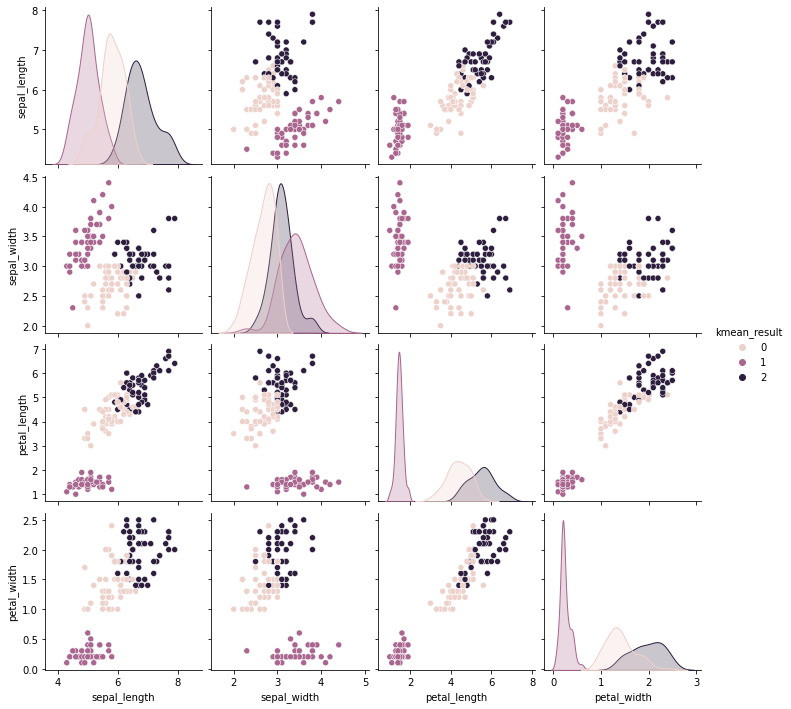

In [23]:
import pandas as pd
result_df = pd.concat([X, pd.DataFrame(labels, columns=["kmean_result"])], axis=1)
sns.pairplot(result_df, hue="kmean_result")

折角なので教師ラベルの3クラスと比べてみる

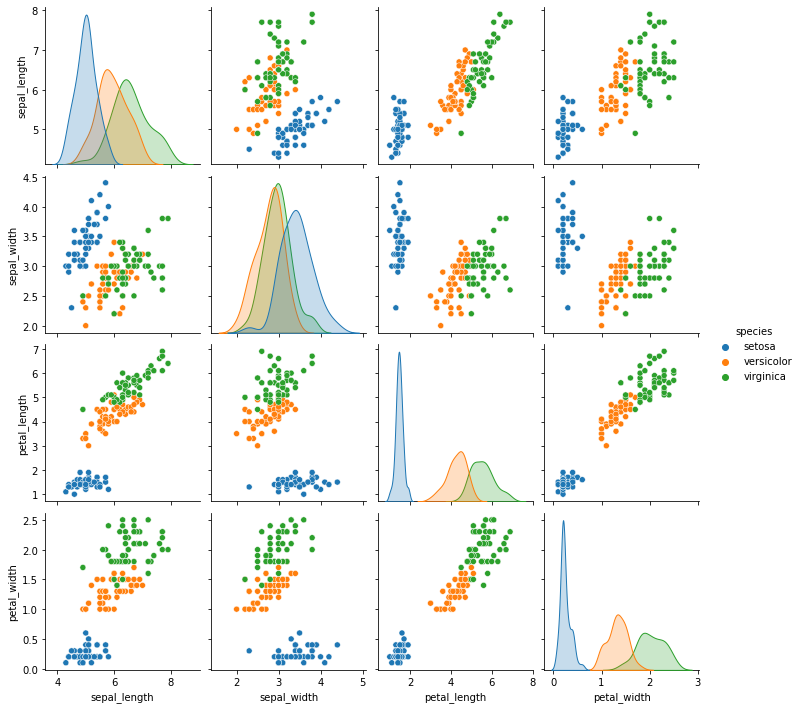

In [32]:
sns.pairplot(df, hue="species")

### 損失を描画

1~9のKで損失を計算する。scoreは値が大きい方が良いようになっているが、今回はただの損失が知りたいのでマイナスをつける。

In [28]:
losses = []
for K in range(1, 10):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
    losses.append(-kmeans.score(X))
losses

[681.3706,
 152.3479517603579,
 78.85144142614601,
 57.228473214285714,
 46.47223015873016,
 39.03998724608725,
 34.299712121212124,
 30.06311061745273,
 28.27172172856384]

Text(0, 0.5, 'loss')

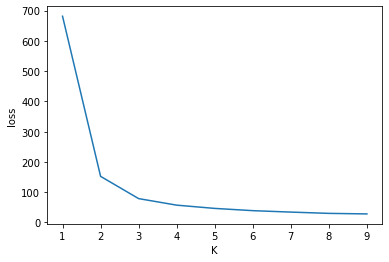

In [31]:
import matplotlib.pyplot as plt
plt.plot(range(1, 10), losses)
plt.xlabel("K")
plt.ylabel("loss")


## 階層クラスタリング(Hierarchical Clustering)
- k-meansと双璧を成す有名クラスタリング手法
- 事前にクラスタ数(K)を指定する必要がない
- dendrogram(樹状図)を作り"階層的に"クラスタリングする
- これも事前に標準化しておく
![樹状図](img/dendrogram.png) 

### 注意点
- ネストできない様なデータに対してもネスト型の階層を作ってしまう<br>
    (Kに応じて分類の軸を変えることができない)

    - 例えば、性別(2) ✖︎ 職業(3)のデータセットがあった時に、
    K=2なら性別で分け、K=3なら職業で分けることができない。
    
    → 別のクラスタリング手法を使う


### 簡単な補足説明

#### クラスタ間の距離の測り方

ward(ウォード法)
- 全データの中心から各データの距離の二乗和から、それぞれのクラスタの中心とそのクラスタ内のデータの距離の二乗和を引いた値
- 計算量は多いが分類の感度が良いのでよく使われる
![ウォード法](img/ward.png) 

#### 類似度(距離)

基本はユークリッド距離を用いるが、距離ではうまくクラスタリングできないケースでは相関を使うことでうまくできることがある。
![表](img/graph01.png) 
距離でクラスタリングをすると、頻繁に買った人とそうでない人(2,3かそれ以外か)で分類されてしまう

→ 相関を使うことで、似た購買歴がある人(3,4や2,5など)をクラスタリングできる

#### dendrogramの使い方


縦軸の任意の箇所で切る事で好きなクラスタ数でクラスタリングが可能
![dendrogramの使い方](img/dendrogram%E3%81%AE%E4%BD%BF%E3%81%84%E6%96%B9.png) 
dendrogram上の横軸でデータが近いからといって、実際のデータが近いとは限らない点に注意。クラスタ内のデータの並びにはなんの意味もない。

### 階層クラスタリングを行う
scipy.cluster.hierarchy.linkage<br>
- linkage(X, method)でクラスタリング実施
    - method引数には'single', 'average', 'complete', 'centroid', 'ward'等を指定
- dendrogramを構成する情報をNumPy Arrayで返す
    - [クラスタ1のindex, クラスタ2のindex, 距離, データの数]
        - index < データ数 : indexは学習データのindex(クラスタ=データ)
        - index > データ数 : indexはlinkageの戻り値のindex
        

In [61]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_scaled, method="ward")

#### Zについて

In [54]:
Z[13], len(X_scaled)

(array([ 40.        , 154.        ,   0.17221655,   3.        ]), 150)

データの数が3なので、片方に1つ、もう片方に2つデータがあることがわかる。<br>
40 < データの数(len(X_scaled) = 150) なので、1つはただのデータ(X_scaled[40])。<br>
154 > データの数なので、もう1つはindex154のクラスターである。<br>


最初は各データがクラスターになっているので、index154のクラスターは、154-len(X_scaled) 番目、即ち4番目に合体したクラスターのことである。

In [57]:
Z[154-len(X_scaled)] # Z[4]

array([ 0.        , 17.        ,  0.13163218,  2.        ])

これを見ると、4番目に合体したクラスターは0番目のデータと17番目のデータのクラスターであることがわかる。

In [58]:
X_scaled[0],X_scaled[17]

(array([-0.90068117,  1.01900435, -1.34022653, -1.3154443 ]),
 array([-0.90068117,  1.01900435, -1.34022653, -1.18381211]))

確認すると、確かになんとなく近い。

### Dendrogramを描画
scipy.cluster.hierarchy.dendrogram
- dendrogram(Z)でdendrogramを描画
- Zにはlinkageの戻り値を入れる
- truncate_mode引数およびp引数で任意の高さでdendrogramを切る
    - truncate_mode='lastp', p=クラスタ数 : 指定したp個のクラスタになるようにdendrogramを切る
    - truncate_model='level', p=段数 : p段になるようにdendrogramを切る

戻り値が長いので、dで受けとって描画だけ行う

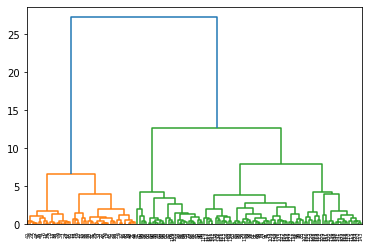

In [68]:
d = dendrogram(Z)

クラスターが3個になるように切る。

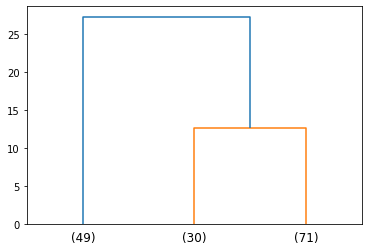

In [70]:
d = dendrogram(Z, truncate_mode='lastp', p=3)

3段になるように切る。

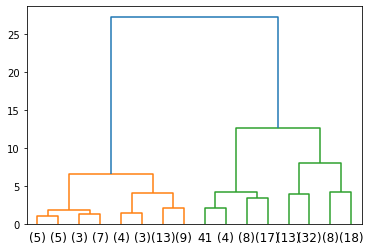

In [67]:
d = dendrogram(Z, truncate_mode='level', p=3)

### 結果を描画
各データのラベル付け

scipy.cluster.hierarchy.fcluster
- Z: linkage関数の戻り値
- criterion引数: どの段階のクラスタ分けを使うか指定
    - 'maxclust': t引数に指定したクラスタ数でラベル付けをする
- t引数: criterion引数によって異なる値を指定する 

In [75]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, criterion="maxclust", t=3)

clustersをDFにして、Xとがっちゃんこ。

In [78]:
hc_result_df = pd.concat([X, pd.DataFrame({"cluster": clusters})], axis=1)
hc_result_df

,sepal_length,sepal_width,petal_length,petal_width,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


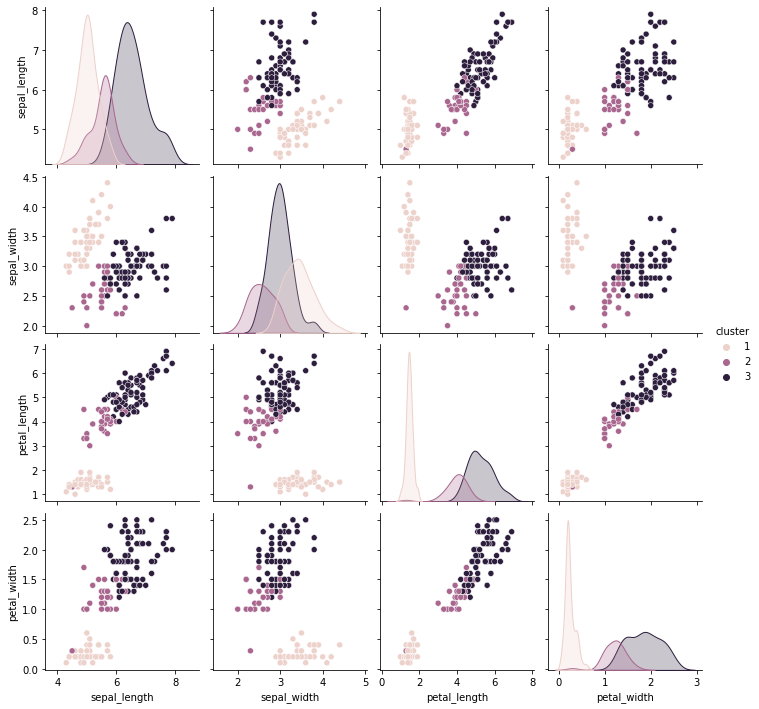

In [79]:
sns.pairplot(hc_result_df, hue="cluster")

折角なので教師ラベルの3クラスと比べてみる

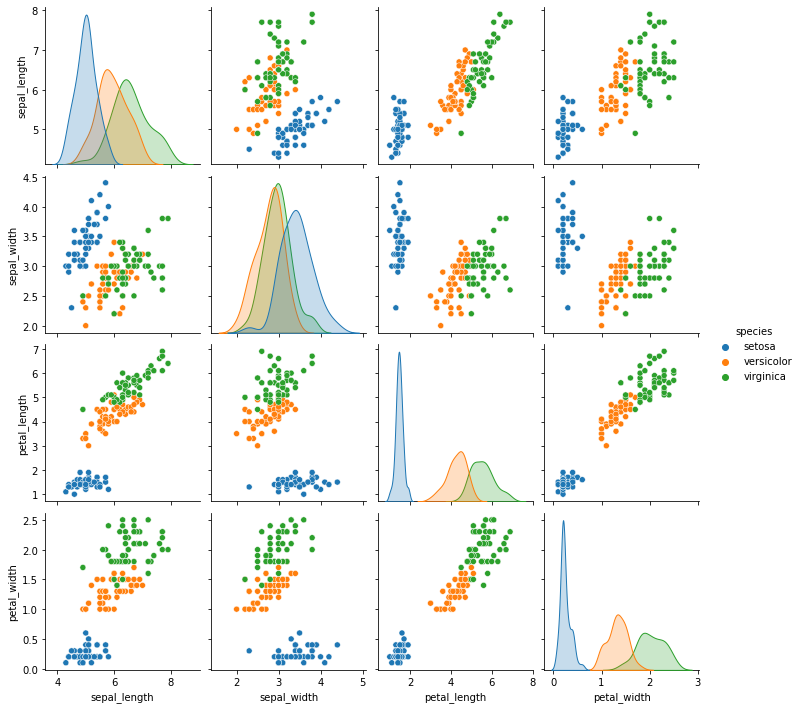

In [80]:
sns.pairplot(df, hue="species")